In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [3]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5', '0.75')#, '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 250002
tok_type = "sp-unigram-merged"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "xlm-roberta-base", multil_string, f"alpha-{alpha}_N-250002", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "xlm-roberta-base", multil_string, f"alpha-{alpha}_N-250002", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [4]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

In [5]:
len(overall_token_dists['0.0'])

250002

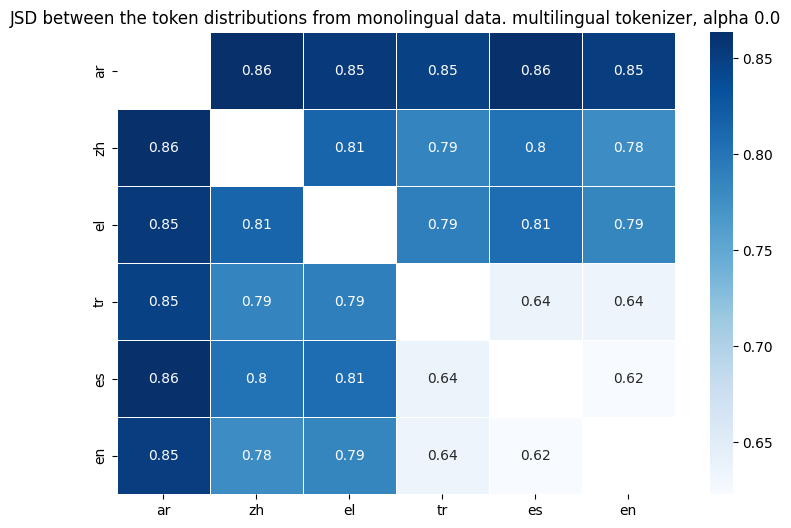

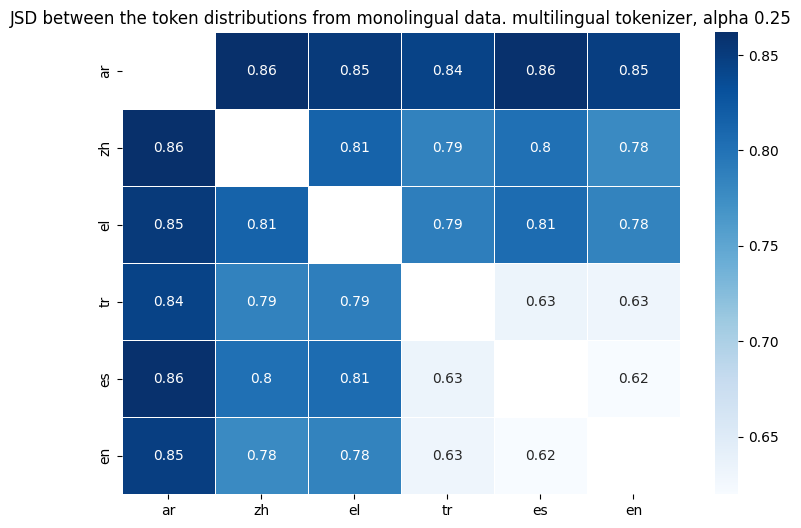

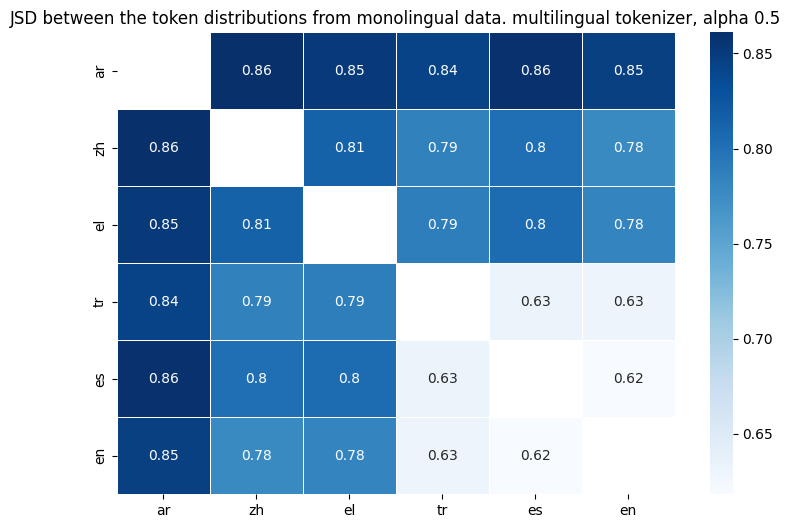

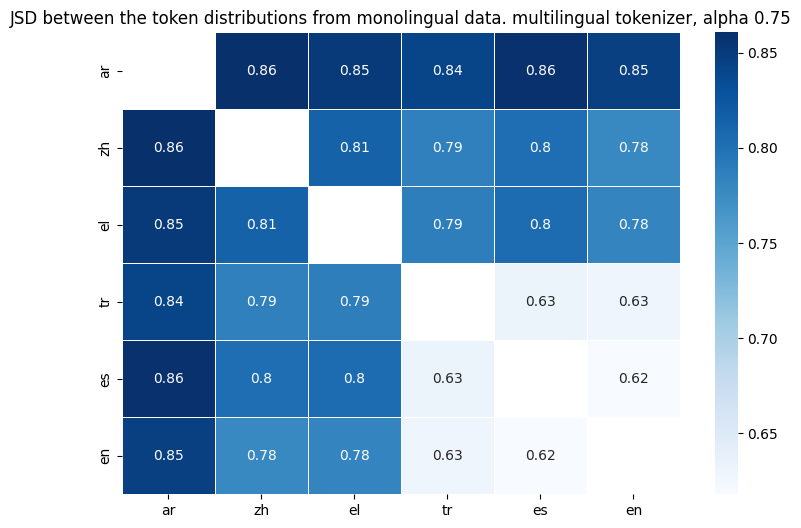

In [6]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2], base=2.) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

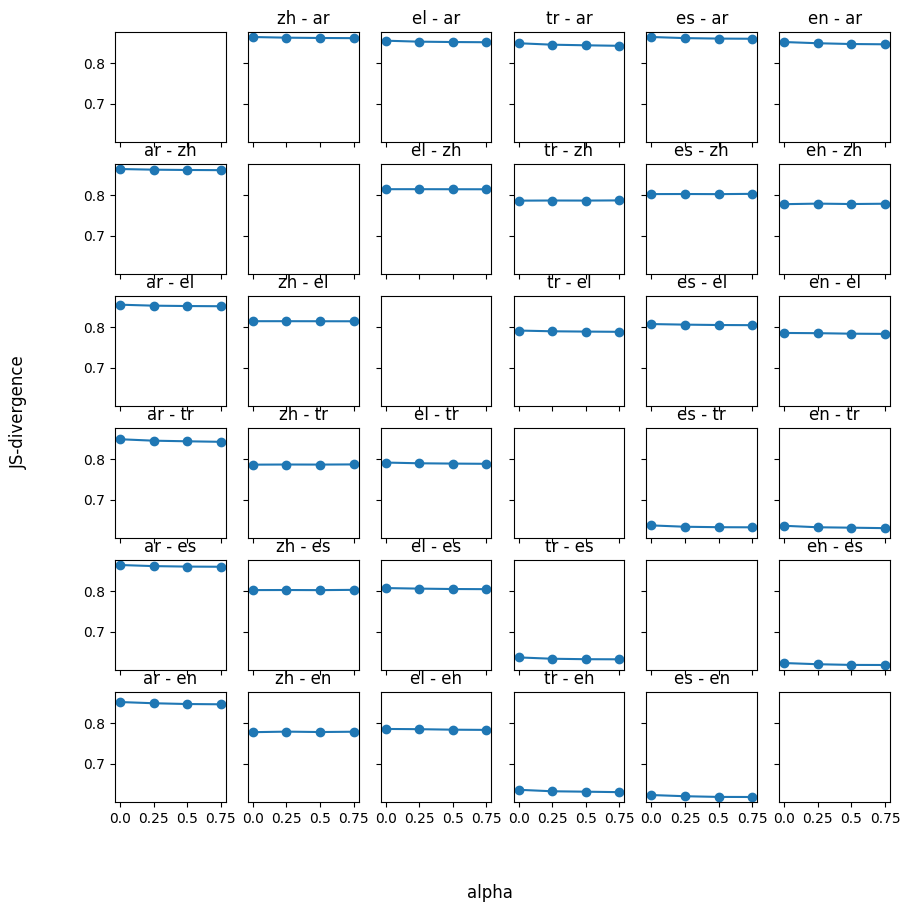

In [7]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


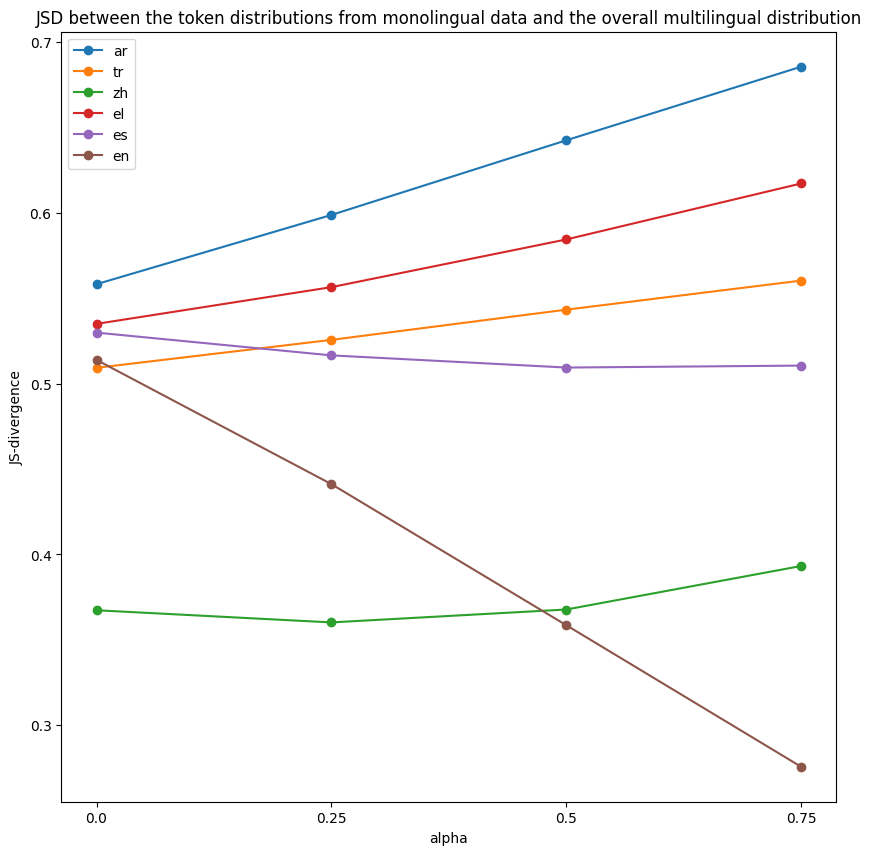

In [8]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

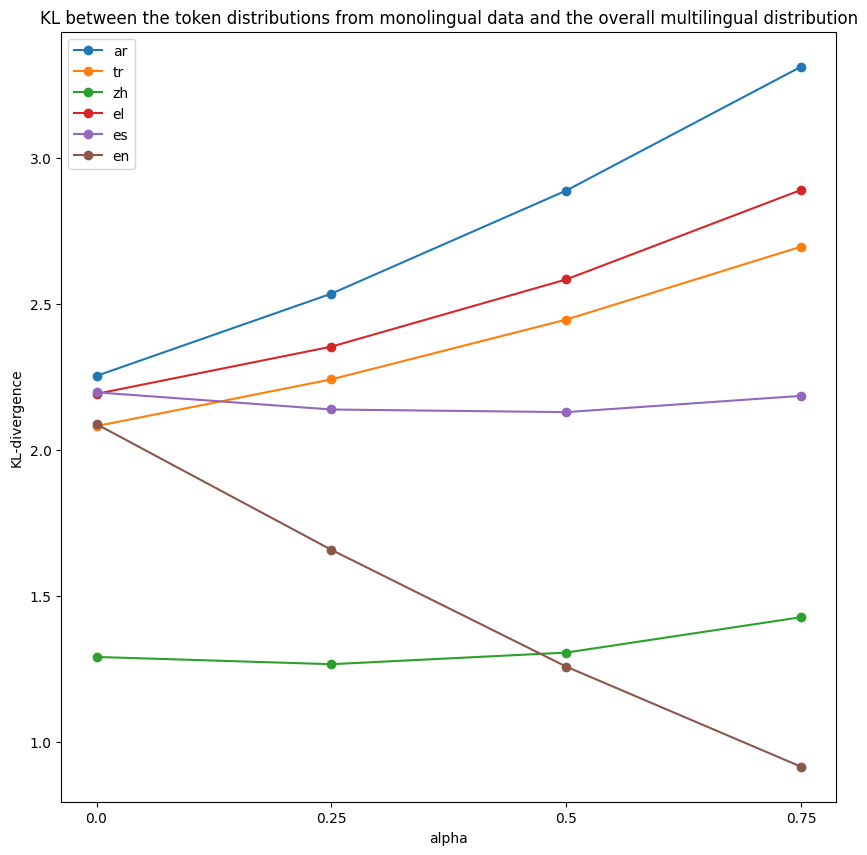

In [9]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.)

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

# Tokenizer profile plot PDFs

<Figure size 640x480 with 0 Axes>

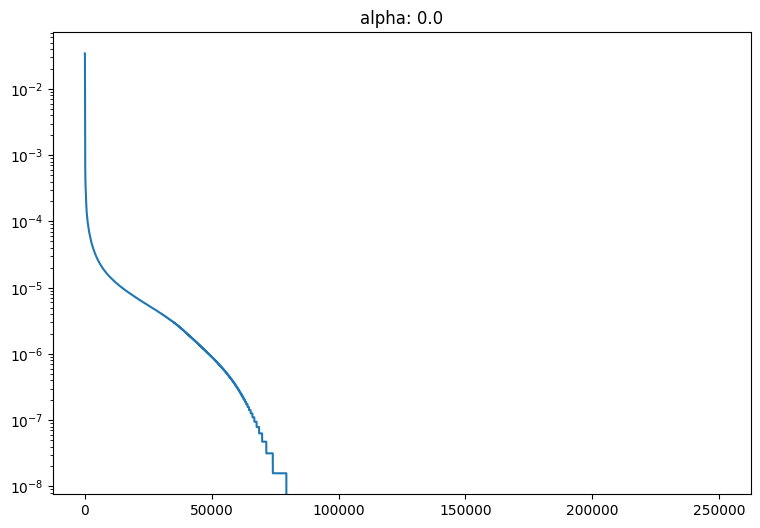

<Figure size 640x480 with 0 Axes>

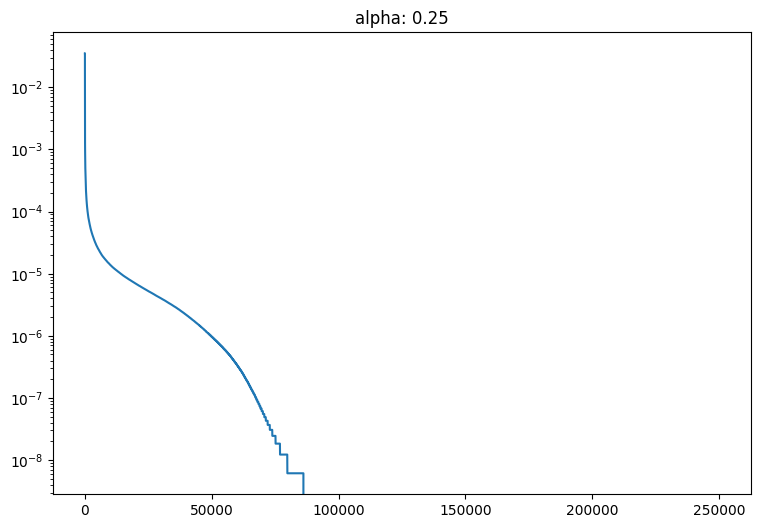

<Figure size 640x480 with 0 Axes>

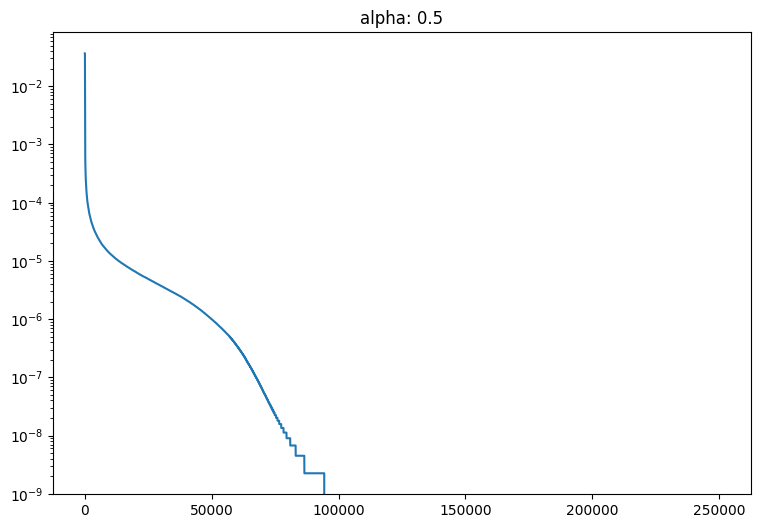

<Figure size 640x480 with 0 Axes>

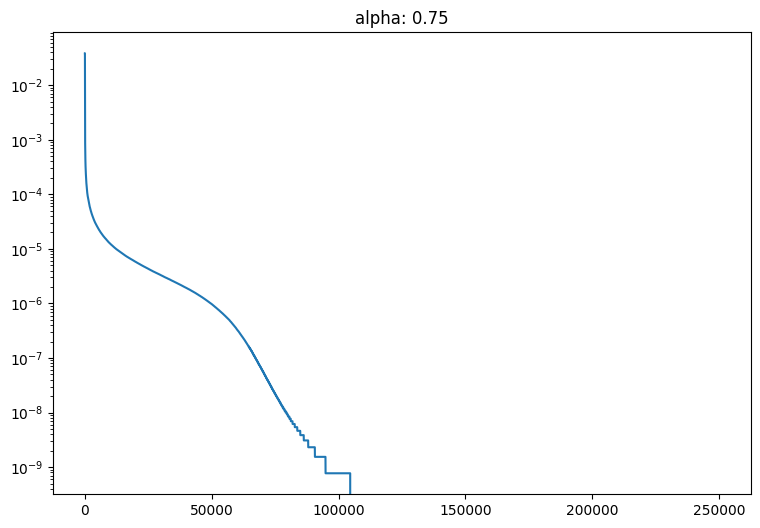

In [10]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(sorted_data)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    plt.show()


# For each language

<Figure size 640x480 with 0 Axes>

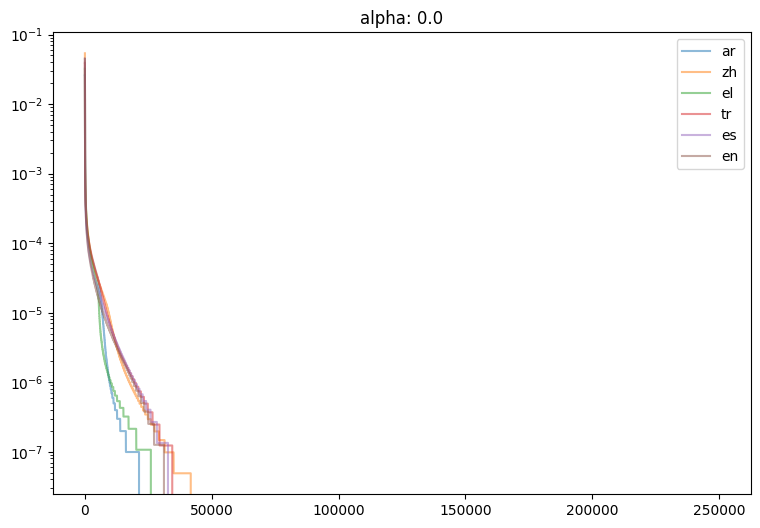

<Figure size 640x480 with 0 Axes>

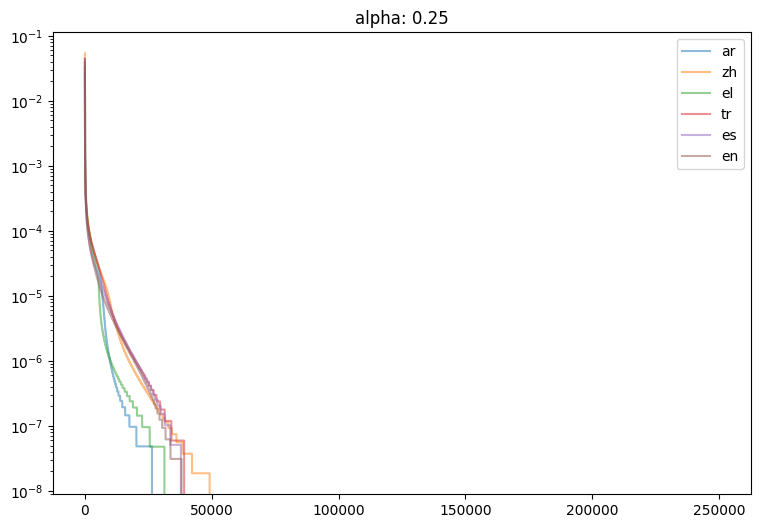

<Figure size 640x480 with 0 Axes>

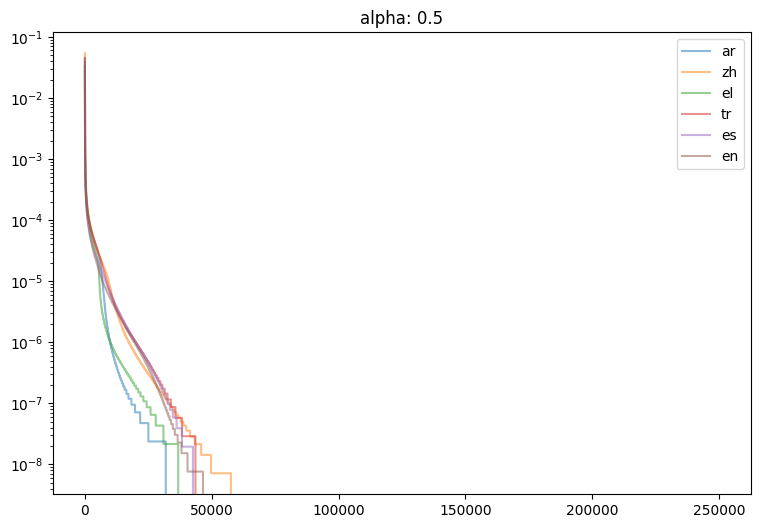

<Figure size 640x480 with 0 Axes>

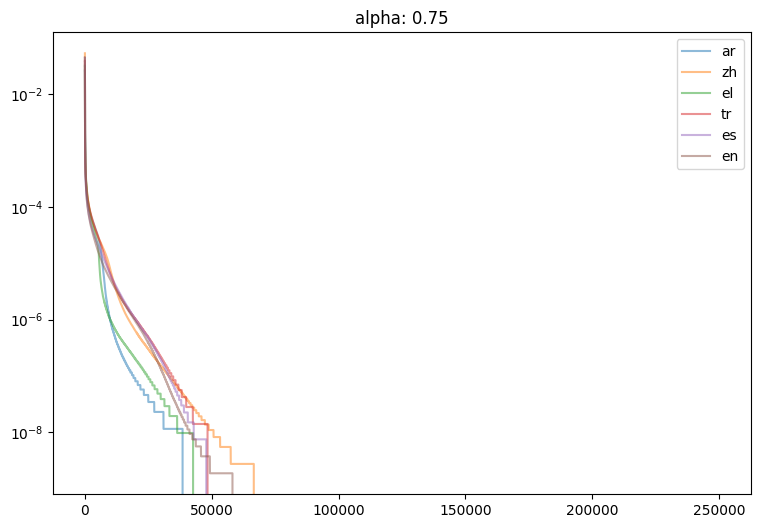

In [11]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(sorted_data, label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()

# CDFs

<Figure size 640x480 with 0 Axes>

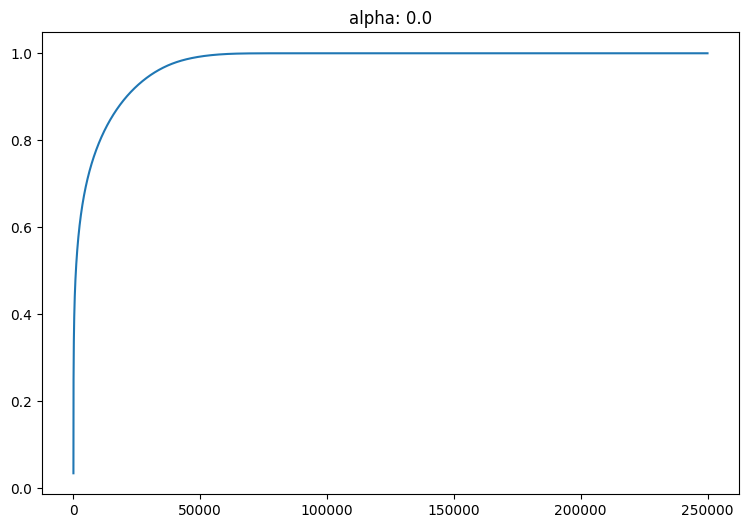

quatniles: 0.90, 0.95, 0.99, 0.999: [20909, 30433, 47537, 63183]
average rank: 6162


<Figure size 640x480 with 0 Axes>

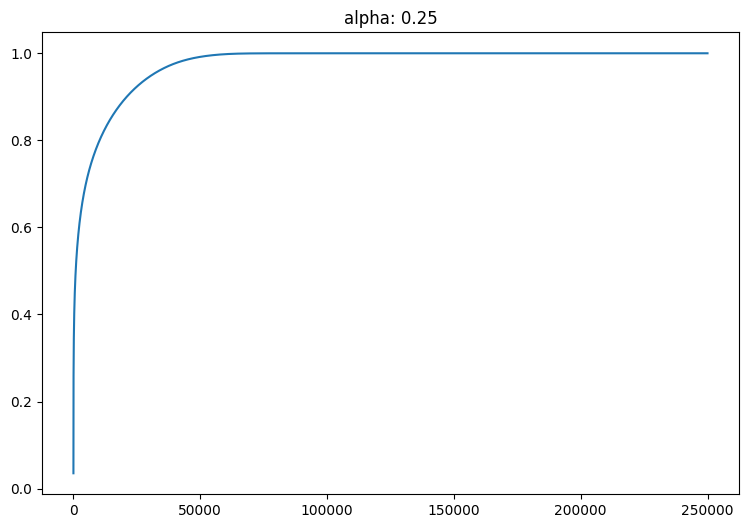

quatniles: 0.90, 0.95, 0.99, 0.999: [21004, 30927, 48274, 63863]
average rank: 6143


<Figure size 640x480 with 0 Axes>

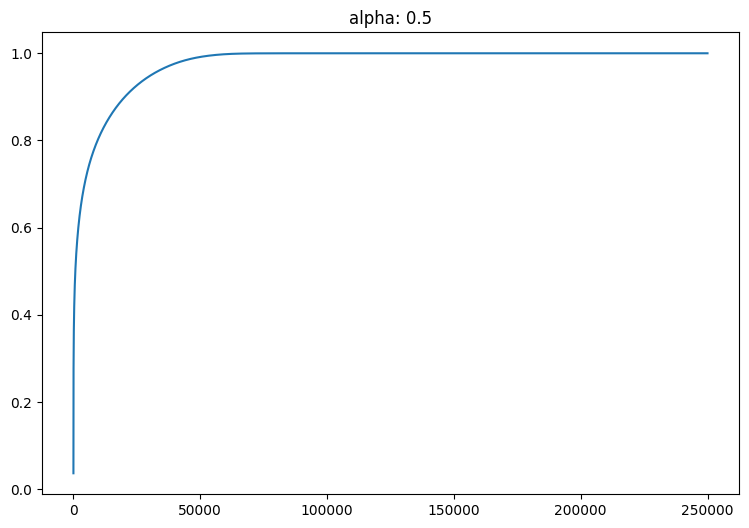

quatniles: 0.90, 0.95, 0.99, 0.999: [20262, 30620, 48493, 64017]
average rank: 5897


<Figure size 640x480 with 0 Axes>

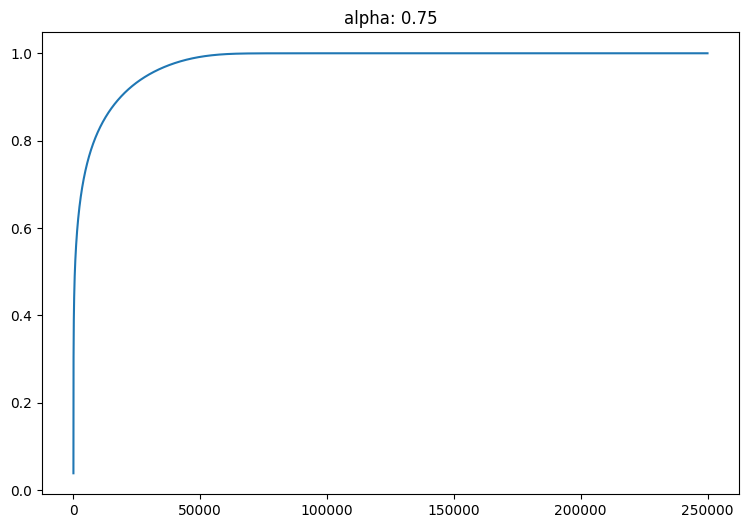

quatniles: 0.90, 0.95, 0.99, 0.999: [18622, 29373, 48261, 63849]
average rank: 5438


In [12]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(np.cumsum(sorted_data))

    ax.set_title(f"alpha: {alpha}")
    plt.show()


    percentile_idx = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
    avg_rang = np.sum(sorted_data * np.arange(len(sorted_data)))
    print(f"quatniles: 0.90, 0.95, 0.99, 0.999: {percentile_idx}")
    print(f"average rank: {np.round(avg_rang):.0f}")

<Figure size 640x480 with 0 Axes>

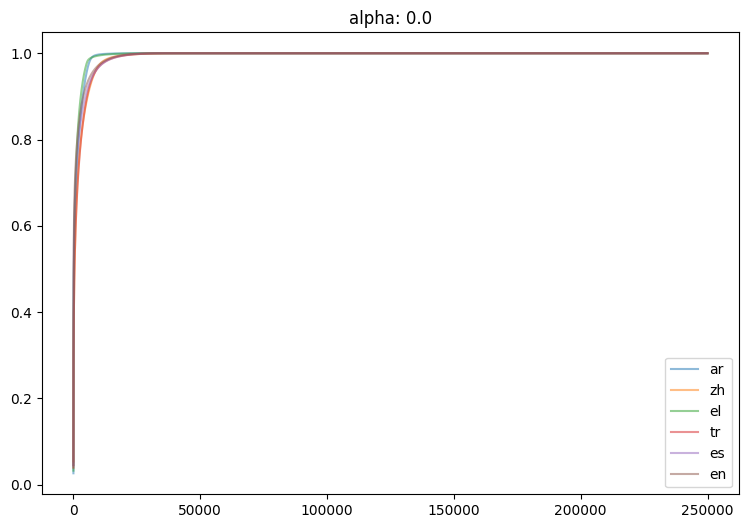

ar percentiles: 0.90, 0.95, 0.99, 0.999: [3681, 5007, 7198, 13750]
ar average rang: 1087
zh percentiles: 0.90, 0.95, 0.99, 0.999: [5583, 8055, 14725, 29221]
zh average rang: 1810
el percentiles: 0.90, 0.95, 0.99, 0.999: [2882, 4137, 7092, 18423]
el average rang: 918
tr percentiles: 0.90, 0.95, 0.99, 0.999: [5377, 7932, 16254, 27844]
tr average rang: 1829
es percentiles: 0.90, 0.95, 0.99, 0.999: [4723, 7795, 16130, 26821]
es average rang: 1474
en percentiles: 0.90, 0.95, 0.99, 0.999: [3871, 6905, 15236, 25213]
en average rang: 1258


<Figure size 640x480 with 0 Axes>

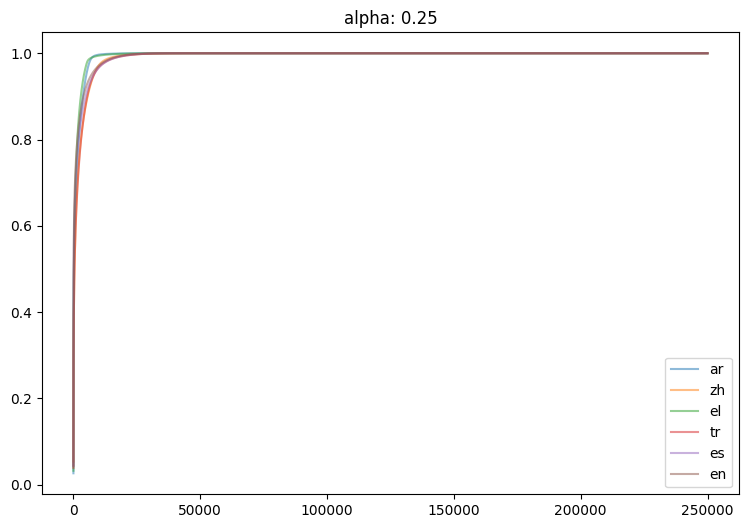

ar percentiles: 0.90, 0.95, 0.99, 0.999: [3748, 5076, 7300, 14865]
ar average rang: 1116
zh percentiles: 0.90, 0.95, 0.99, 0.999: [5585, 8037, 14703, 30224]
zh average rang: 1814
el percentiles: 0.90, 0.95, 0.99, 0.999: [2897, 4154, 7172, 19768]
el average rang: 928
tr percentiles: 0.90, 0.95, 0.99, 0.999: [5437, 8041, 16794, 29358]
tr average rang: 1859
es percentiles: 0.90, 0.95, 0.99, 0.999: [4797, 7952, 16730, 28369]
es average rang: 1507
en percentiles: 0.90, 0.95, 0.99, 0.999: [3939, 7068, 15834, 26848]
en average rang: 1296


<Figure size 640x480 with 0 Axes>

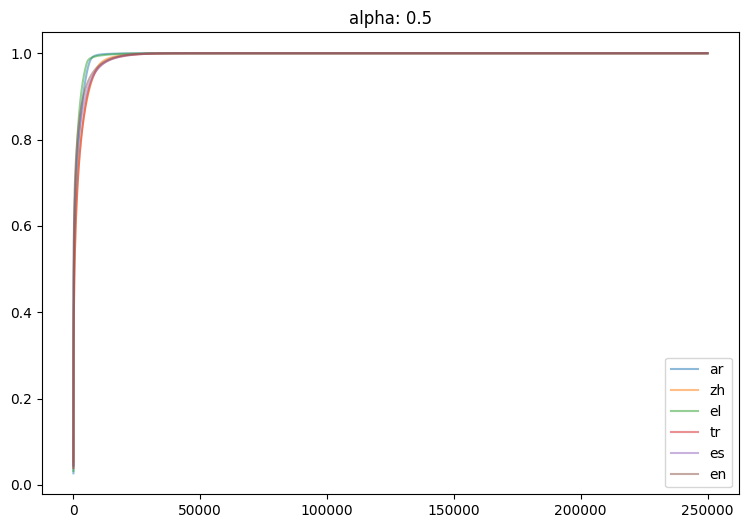

ar percentiles: 0.90, 0.95, 0.99, 0.999: [3775, 5104, 7353, 15454]
ar average rang: 1129
zh percentiles: 0.90, 0.95, 0.99, 0.999: [5590, 8035, 14695, 30742]
zh average rang: 1817
el percentiles: 0.90, 0.95, 0.99, 0.999: [2916, 4176, 7234, 20675]
el average rang: 937
tr percentiles: 0.90, 0.95, 0.99, 0.999: [5437, 8039, 16961, 30186]
tr average rang: 1864
es percentiles: 0.90, 0.95, 0.99, 0.999: [4782, 7951, 16838, 29058]
es average rang: 1507
en percentiles: 0.90, 0.95, 0.99, 0.999: [3921, 7062, 16021, 27430]
en average rang: 1296


<Figure size 640x480 with 0 Axes>

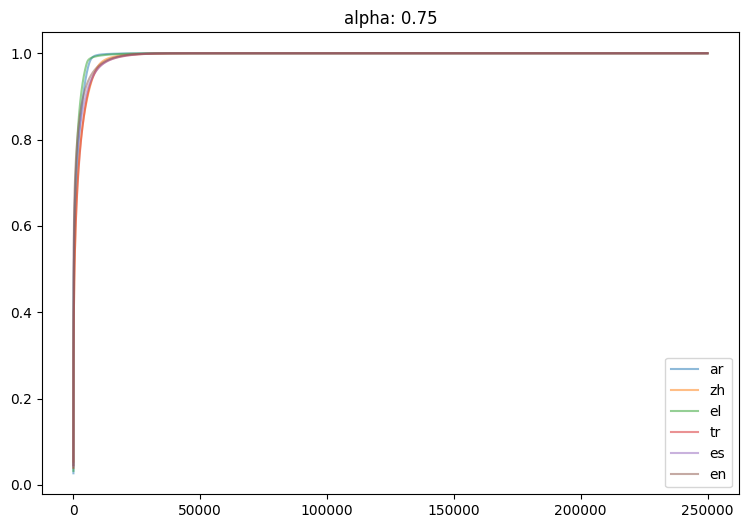

ar percentiles: 0.90, 0.95, 0.99, 0.999: [3772, 5108, 7379, 16191]
ar average rang: 1129
zh percentiles: 0.90, 0.95, 0.99, 0.999: [5587, 8016, 14616, 30862]
zh average rang: 1816
el percentiles: 0.90, 0.95, 0.99, 0.999: [2922, 4186, 7276, 21392]
el average rang: 943
tr percentiles: 0.90, 0.95, 0.99, 0.999: [5435, 8036, 17102, 30759]
tr average rang: 1867
es percentiles: 0.90, 0.95, 0.99, 0.999: [4787, 7957, 16861, 29374]
es average rang: 1509
en percentiles: 0.90, 0.95, 0.99, 0.999: [3888, 7027, 16015, 27573]
en average rang: 1289


In [14]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    avg_rangs = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(np.cumsum(sorted_data), label=lang, alpha=0.5)
        percentile_idx[lang] = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
        avg_rangs[lang] = np.sum(sorted_data * np.arange(len(sorted_data)))
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()
    for lang in languages:
        print(f"{lang} percentiles: 0.90, 0.95, 0.99, 0.999: {percentile_idx[lang]}")
        print(f"{lang} average rang: {np.round(avg_rangs[lang]):.0f}")